### **2018 Data Science Bowl - Nucleus segmentation**
Find the nuclei in divergent images to advance medical discovery

#### **1. Download the dataset**

In [ ]:
# Kaggle API를 통해 dataset 다운로드
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

!chmod 600 ./kaggle.json
!kaggle competitions download -c data-science-bowl-2018
!unzip -q ./data-science-bowl-2018.zip -d .

!mkdir ./nucleus/
!unzip -q ./stage1_train.zip -d ./nucleus/

data_root_dir = './nucleus/'

#### **2. Explore the dataset**

In [ ]:
# OS 디렉토리 구조에서 image_id / image_name / mask_name 경로 추출 로직 함수화
def get_image_id_list(data_root_dir):
    image_id_list = []
    for image_id in sorted(next(os.walk(data_root_dir))[1]):
        image_id_list.append(image_id)
    return image_id_list

image_id_list = get_image_id_list(data_root_dir)
for image_id in image_id_list[:3]:
    print(f'image_id : {image_id}')
    
def get_image_name_list(data_root_dir):
    image_name_list = []
    for image_id in sorted(next(os.walk(data_root_dir))[1]):
        image_id_path = os.path.join(data_root_dir, image_id)
        image_path = os.path.join(image_id_path, 'images')
        for image_name in sorted(next(os.walk(image_path))[2]):
            image_name_list.append(os.path.join(image_path, image_name))
    return image_name_list

image_name_list = get_image_name_list(data_root_dir)
for image_name in image_name_list[:3]:
    print(f'image_name : {image_name}')

def get_mask_name_list(image_id_path):
    mask_path = os.path.join(image_id_path, 'masks')
    mask_name_list = []
    for mask_name in sorted(next(os.walk(mask_path))[2]):
        if '.png' in mask_name:
            mask_name_list.append(os.path.join(mask_path, mask_name))
    return mask_name_list
    
mask_name_list = get_mask_name_list(os.path.join(data_root_dir, image_id_list[0]))
for mask_name in mask_name_list[:3]:
    print(f'mask_name : {mask_name}')

image_id : 00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
image_id : 003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
image_id : 00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
image_name : ./nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png
image_name : ./nucleus/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png
image_name : ./nucleus/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png
mask_name : ./nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png
mask_name : ./nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb

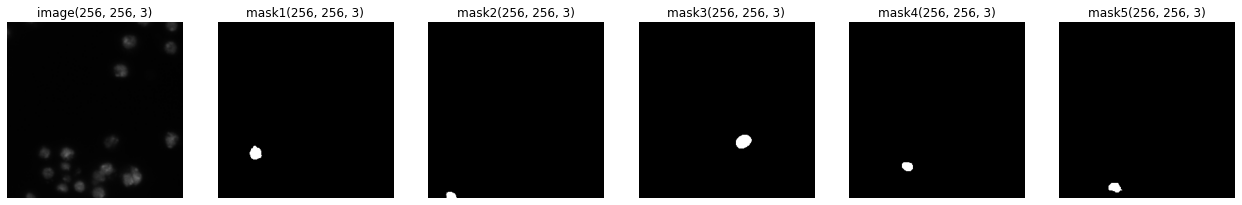

In [ ]:
# image / image와 매칭되는 mask 파일 시각화 진행
import matplotlib.pyplot as plt
import cv2

def show_image_mask(image_name_list, mask_name_list, ncols):
    fig, axs = plt.subplots(figsize=(22, 5), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = image_name_list if i == 0 else mask_name_list[i-1]
        image_cvt = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        axs[i].imshow(image_cvt)
        axs[i].set_title('image' + str(image_cvt.shape) if i == 0 else 'mask' + str(i) + str(image_cvt.shape))
        axs[i].axis('off')

show_image_mask(image_name_list[0], mask_name_list[:5], ncols=6)

#### **3. K-Means clustering(stained / brightfield / fluorescence)**

In [ ]:
# 단일 image에 대한 K-Means clustering 진행
from sklearn.cluster import KMeans

image_array = cv2.imread(image_name_list[0])
# image H(Hue)S(Saturation)V(Value) 변환 > image 특징에 따라, HSV 값을 적용한 clustering이 가장 효과적인 점 확인
image_cvt = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)
print(f'image_cvt shape : {image_cvt.shape}')

# KMeans clustering은 2d array 입력을 필요로 함 > reshape(h*w /c) 진행
image_cvt_reshaped = image_cvt.reshape((image_cvt.shape[0] * image_cvt.shape[1], image_cvt.shape[2]))
print(f'image_cvt_reshaped shape : {image_cvt_reshaped.shape}')

# KMeans clustering 결과, 단일 image 내 cluster centroid 반환
kmeans = KMeans(n_clusters=1)
kmeans.fit(image_cvt_reshaped)
print(f'image_hsv_reshaped array after clustering : {image_cvt_reshaped}')
print(f'kmeans_cluster_center : {kmeans.cluster_centers_}')

image_cvt shape : (256, 256, 3)
image_cvt_reshaped shape : (65536, 3)
image_hsv_reshaped array after clustering : [[0 0 5]
 [0 0 5]
 [0 0 5]
 ...
 [0 0 2]
 [0 0 2]
 [0 0 2]]
kmeans_cluster_center : [[0.         0.         6.14222717]]


In [ ]:
# image_name_list의 모든 image의 centroid를 기반으로, n_cluster에 맞춘 clustering 진행 로직 함수화
import numpy as np
from tqdm.notebook import tqdm

def get_cluster_center(image_cvt, n_cluster):
    image_cvt_reshaped = image_cvt.reshape((image_cvt.shape[0] * image_cvt.shape[1], image_cvt.shape[2]))
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(image_cvt_reshaped)
    return kmeans.cluster_centers_ 

def get_cluster_results(image_name_list, n_clusters):
    cluster_centers = []
    # tqdm 모듈로 iterable한 자료형 데이터의 progress bar 출력
    for image_name in tqdm(image_name_list):
        image_array = cv2.imread(image_name)
        image_cvt = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)
        cluster_center = get_cluster_center(image_cvt, n_cluster=1)
        cluster_centers.append(cluster_center.squeeze())
    
    cluster_centers_array = np.array(cluster_centers)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(cluster_centers_array)
    cluster_results = kmeans.predict(cluster_centers_array)
    return cluster_results

pred_clusters = get_cluster_results(image_name_list, n_clusters=3)
print(pred_clusters)

  0%|          | 0/670 [00:00<?, ?it/s]

[0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 2 0 2 0 0
 2 0 2 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0
 0 0 1 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 2 1 0 0 0 2 0 0
 0 0 2 0 0 0 2 0 0 0 0 0 2 0 0 0 0 2 2 0 2 0 0 0 2 0 1 0 2 2 0 0 0 0 0 0 2
 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1
 2 0 1 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0
 2 0 2 0 0 0 0 0 0 0 2 2 2 0 0 0 2 0 0 1 0 0 0 2 0 2 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 2 1 0 2 0 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 2 0 0 0 2 0 0 1 0 0 0 2 0 0 0 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0 0 2 2 0 0
 2 0 0 0 0 2 0 0 0 0 2 0 0 2 0 0 2 0 2 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 

#### **4. Create a dataframe**

In [ ]:
# image_id / image & mask 경로 / cluster 정보가 포함된 dataframe 생성 > debugging에 용이
import pandas as pd

def make_meta_df(data_root_dir):
    mask_name_path = []
    for image_id in image_id_list:
        mask_name_list = get_mask_name_list(os.path.join(data_root_dir, image_id))
        mask_name_path.append(mask_name_list)

    meta_df = pd.DataFrame({'image_id_list' : image_id_list,
                            'image_name_path' : image_name_list,
                            'mask_name_path': mask_name_path,
                            'cluster_list': pred_clusters})
    return meta_df

meta_df = make_meta_df(data_root_dir)
pd.set_option('display.max.colwidth', 100)
meta_df

,image_id_list,image_name_path,mask_name_path,cluster_list
0,00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552,./nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba...,[./nucleus/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af...,0
1,003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1,./nucleus/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/003cee89357d9f...,[./nucleus/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/masks/1811379154b848...,0
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e,./nucleus/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631a...,[./nucleus/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/masks/00521bc3b6a133...,2
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed,./nucleus/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed/images/0121d6759c5adb...,[./nucleus/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed/masks/02b233e3388fc3...,2
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf,./nucleus/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/images/01d44a26f6680c...,[./nucleus/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf/masks/34e5959f808f79...,2
...,...,...,...,...
665,fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce93a43f4044eababed5,./nucleus/fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce93a43f4044eababed5/images/fec226e45f49ab...,[./nucleus/fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce93a43f4044eababed5/masks/05f27b775aac57...,0
666,feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398,./nucleus/feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398/images/feffce59a1a3eb...,[./nucleus/feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398/masks/0d320e6d783d4f...,0
667,ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22fa618ac6e6599d0bb3,./nucleus/ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22fa618ac6e6599d0bb3/images/ff3407842ada5b...,[./nucleus/ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22fa618ac6e6599d0bb3/masks/38e1084d639f41...,0
668,ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0,./nucleus/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0/images/ff3e512b5fb860...,[./nucleus/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0/masks/04cc75be64cb99...,0


#### **5. Visualize the data**

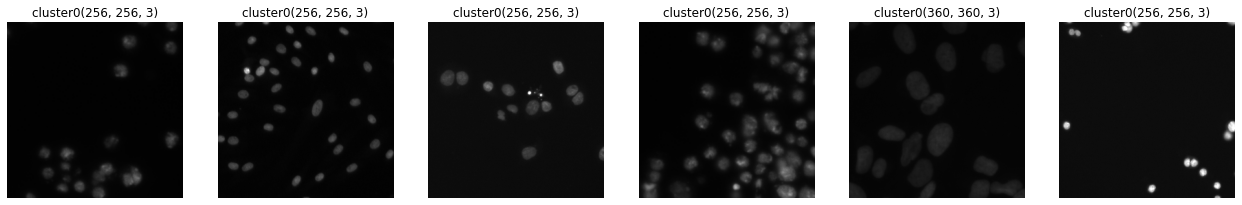

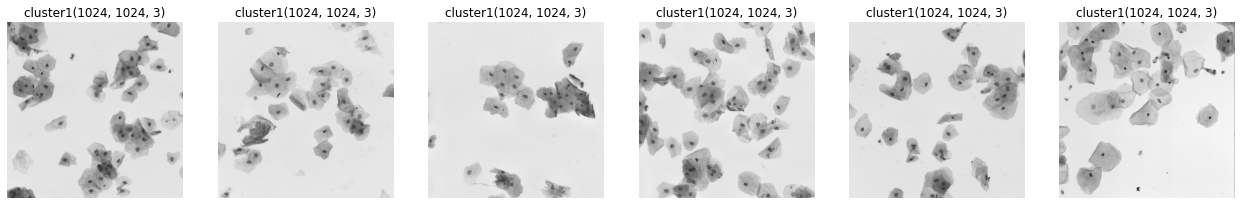

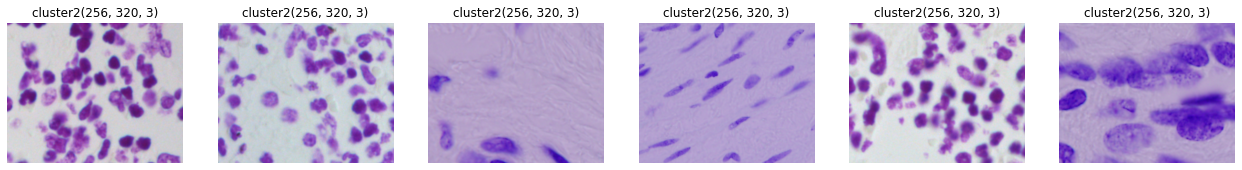

In [ ]:
# cluster 구분에 따른 image 파일 시각화 진행
def show_cluster_image(n_cluster, ncols):
    fig, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    cluster_image = meta_df[meta_df['cluster_list'] == n_cluster]['image_name_path'].to_list()
    for i in range(ncols):
        cluster_image_cvt = cv2.cvtColor(cv2.imread(cluster_image[i]), cv2.COLOR_BGR2RGB)
        axs[i].imshow(cluster_image_cvt)
        axs[i].set_title('cluster' + str(n_cluster) + str(cluster_image_cvt.shape))
        axs[i].axis('off')

def show_cluster_images(n_cluster, ncols):
    for i in range(n_cluster):
        show_cluster_image(n_cluster=i, ncols=ncols)

show_cluster_images(n_cluster=3, ncols=6)

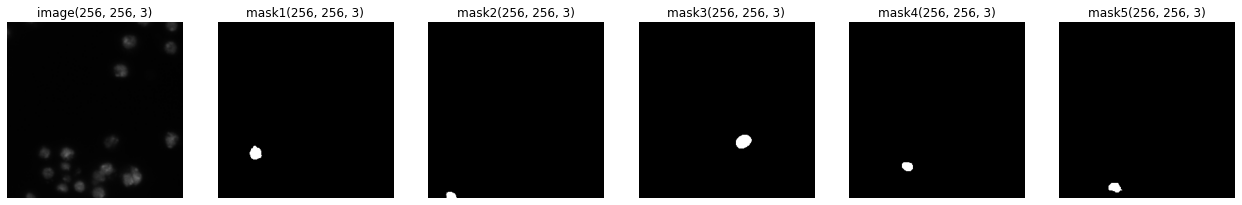

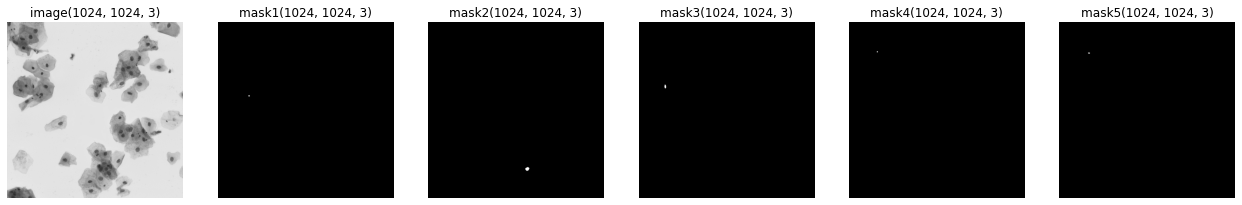

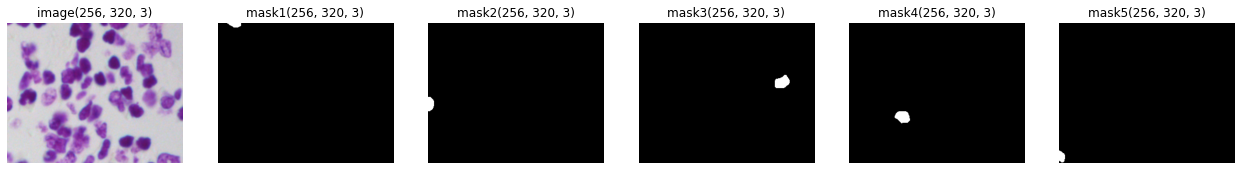

In [ ]:
# cluster 구분에 따른 image / mask 파일 시각화 진행
def show_cluster_image_n_masks(n_cluster, ncols):
    for i in range(n_cluster):
        cluster_meta_df = meta_df[meta_df['cluster_list'] == i][['image_name_path', 'mask_name_path']].iloc[0, :]
        cluster_image_name = cluster_meta_df['image_name_path']
        cluster_mask_name = cluster_meta_df['mask_name_path']
        show_image_mask(cluster_image_name, cluster_mask_name[:5], ncols=ncols)

show_cluster_image_n_masks(n_cluster=3, ncols=6)

#### **6. Find and draw contours**

In [ ]:
# 단일 mask에 대한 외곽선 정보 추출
mask = meta_df['mask_name_path'][0][0]
mask_array = cv2.imread(mask)
print(f'mask_array.shape : {mask_array.shape}')

contours, hierarchy = cv2.findContours(mask_array[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'contours shape : {contours[0].shape}, / contours[0][0] : {contours[0][0]}')

mask_array_copy = mask_array.copy()
contoured_mask_array = cv2.drawContours(mask_array_copy, contours, -1, (0, 255, 0), 2)# 단일 mask에 대한 외곽선 정보 추출

ploygons = [s.ravel().tolist() for s in contours]
print(f'polygons : {ploygons}')

mask_array.shape : (256, 256, 3)
contours shape : (32, 1, 2), / contours[0][0] : [[ 52 180]]
polygons : [[52, 180, 51, 181, 51, 182, 49, 184, 48, 184, 48, 186, 47, 187, 47, 188, 46, 189, 46, 192, 47, 193, 47, 195, 48, 196, 48, 197, 49, 198, 50, 198, 51, 199, 56, 199, 57, 198, 58, 198, 59, 197, 61, 197, 62, 196, 62, 195, 63, 194, 62, 193, 62, 187, 61, 186, 61, 185, 59, 183, 57, 183, 54, 180]]


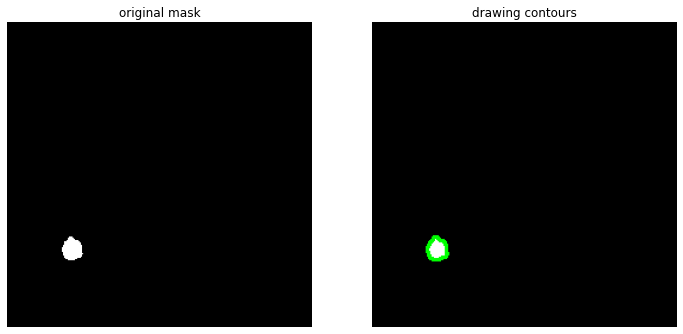

In [ ]:
# 단일 mask에서 추출된 외곽선 시각화 진행
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
axs[0].imshow(mask_array)
axs[0].set_title('original mask')
axs[0].axis('off')

axs[1].imshow(contoured_mask_array)
axs[1].set_title('drawing contours')
axs[1].axis('off')
plt.show()

#### **7. Get annotation information**

In [ ]:
# 모든 mask의 polygons / bounding box(x1, y1, w, h) 정보 추출 로직 함수화
import pycocotools.mask as maskUtils

def get_bbox_info(segmentations):
    x_min = float("inf")
    y_min = float("inf")
    x_max = 0
    y_max = 0
    for s in segmentations:
        x, y, w, h = cv2.boundingRect(s)
        x_b = x + w
        y_b = y + h
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x_b)
        y_max = max(y_max, y_b)
    return x_min, y_min, x_max - x_min, y_max - y_min

def check_polygons(mask_path, polygons, h, w):
    try:
        rles = maskUtils.frPyObjects(polygons, h, w)
        rle = maskUtils.merge(rles)
    except Exception as e:
        print(f'> polygon error : {e, polygons}')

def get_annotation_info(mask_path, mask_name):
    mask_array = cv2.imread(os.path.join(mask_path, mask_name))
    contours, hierarchy = cv2.findContours(mask_array[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentations = [contour for contour in contours if contour.shape[0] > 2]
    xmin, ymin, bwidth, bheight = get_bbox_info(segmentations)
    polygons = [s.ravel().tolist() for s in segmentations]
    check_polygons(mask_path, polygons, mask_array.shape[0], mask_array.shape[1])
    if polygons == []:
        return None, None 
    else: 
        return polygons, [xmin, ymin, bwidth, bheight]

polygons, bbox = get_annotation_info('./nucleus/ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8/masks', 
                                     '5c69eea1e0d21c5973180d464a5ed62572d953a3917bb95d8e8c71915b29a194.png')
print(f'polygons : {ploygons}')
print(f'bbox : {bbox}')

polygons : [[52, 180, 51, 181, 51, 182, 49, 184, 48, 184, 48, 186, 47, 187, 47, 188, 46, 189, 46, 192, 47, 193, 47, 195, 48, 196, 48, 197, 49, 198, 50, 198, 51, 199, 56, 199, 57, 198, 58, 198, 59, 197, 61, 197, 62, 196, 62, 195, 63, 194, 62, 193, 62, 187, 61, 186, 61, 185, 59, 183, 57, 183, 54, 180]]
bbox : [0, 10, 12, 15]


#### **8. Convert the dataset to COCO format**

In [ ]:
# COCO dataset format 변환 로직 함수화
import json
import shutil

def convert_nucleus_to_coco(data_root_dir, image_ids, coco_output, image_copy_path):
    images = []
    annotations = []
    categories = []
    id_index = 0

    for image_id in image_ids:
        image_id_path = os.path.join(data_root_dir, image_id)
        image_name_path = os.path.join(image_id_path, 'images/' + image_id + '.png')
        image_name = image_id + '.png'
        h, w = cv2.imread(image_name_path).shape[0:2]
        image_info = dict(file_name=image_name,
                          height=h,
                          width=w,
                          id=image_id)
        images.append(image_info)
        shutil.copy(image_name_path, os.path.join(image_copy_path, image_name))

        mask_path = os.path.join(image_id_path, 'masks')
        mask_name_path = sorted(next(os.walk(mask_path))[2])
        for mask_name in mask_name_path:
            polygons, bbox = get_annotation_info(mask_path, mask_name)
            if polygons is None:
                continue
            annotation_info = dict(segmentation=polygons,
                                   area=bbox[2]*bbox[3],
                                   iscrowd=0,
                                   category_id=0,
                                   image_id=image_id,
                                   bbox=bbox,
                                   id = id_index)
            annotations.append(annotation_info)
            id_index += 1
            print(f'image id : {image_id} > process completed')

    coco_format_json = dict(images = images,
                            annotations = annotations,
                            categories = [{'id':0, 'name':'nucleus'}])

    with open(coco_output, 'w') as json_output:
        json.dump(coco_format_json, json_output)

In [ ]:
!mkdir ./coco_output
!mkdir -p ./coco_output/train
!mkdir -p ./coco_output/val

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(meta_df, test_size=0.1, stratify=meta_df['cluster_list'], random_state=42)

train_ids = train_df['image_id_list'].to_list()
val_ids = val_df['image_id_list'].to_list()
print(f'train_ids len : {len(train_ids)} / val_ids len : {len(val_ids)}')

train_ids len : 603 / val_ids len : 67


In [ ]:
convert_nucleus_to_coco('./nucleus/', train_ids, './coco_output/train_coco.json', './coco_output/train')
convert_nucleus_to_coco('./nucleus/', val_ids, './coco_output/val_coco.json', './coco_output/val')

#### **9. Visualize the data using pycocotools**

In [ ]:
from pycocotools.coco import COCO

coco_train = COCO('./coco_output/train_coco.json')
coco_val= COCO('./coco_output/val_coco.json')

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [ ]:
# coco.getCatIds() : catNms에 해당하는 CatIds 리스트 반환
catids = coco_val.getCatIds(catNms=['nucleus'])
print(f'catids : {catids}')

# coco.getImgIds() : CatIds에 따른 ImgIds 리스트 반환
imgids = coco_val.getImgIds(catIds=catids)
print(f'imgids len : {len(imgids)} / imgids : {imgids}')

# coco.loadImgs() : ImgIds에 해당하는 메타 정보 반환
val_image = coco_val.loadImgs(val_ids)[0]
print(f'val_image id : {val_image["id"]}')

# coco.getAnnIds() : 선택 image의 annotation id 반환
annids = coco_val.getAnnIds(imgIds=[val_image['id']], catIds=[0], iscrowd=None)
print(f'annids : {annids}')

# coco.loadAnns() : AnnIds 리스트를 입력받아 해당 image의 annotation 정보 반환
anns = coco_val.loadAnns(annids)
print(f'anns len : {len(anns)} / anns : {anns}')

# segmentation 정보 별도 추출
ann_seg_list = [ann['segmentation'][0] for ann in anns]
print(f'ann_seg_list : {len(ann_seg_list)} / ann_seg_list : {ann_seg_list}')

catids : [0]
imgids len : 67 / imgids : ['fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae', '353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606', 'f81ca7ee25e733ff37240c34c8e3044d9937bb0166e315952ebde3f237ecb86f', '958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f', 'f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300', 'b7a86f4968071e0f963fa87ef314fdd1b6c73a66355431cc53a37e193ba6be9b', '06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca', 'fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba', 'e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2', '9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944', 'd3ce382f190ee24729bd2e80684c11bef72bc9c733cdbbc19a17d2c1b2e775f7', '4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1', 'dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05', 'c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22', '29dd28

In [ ]:
# annotation 내 segmentation 정보 추출하여 instance segmentation 로직 함수화
def get_poolygon_xy(annotations):
    polygon_x = [x for index, x in enumerate(annotations) if index % 2 == 0]
    polygon_y = [x for index, x in enumerate(annotations) if index % 2 == 1]
    polygon_xy = [[x, y] for x, y in zip(polygon_x, polygon_y)]
    polygon_xy = np.array(polygon_xy, np.int32)
    return polygon_xy

def get_mask(mask_shape, polygon_xy):
    mask = np.zeros(mask_shape)
    masked_polygon = cv2.fillPoly(mask, [polygon_xy], 1)
    return masked_polygon

def apply_mask(draw_image, masked_polygon, color, alpha=0.5):
    for c in range(3):
        draw_image[:, :, c] = np.where(masked_polygon == 1, 
                                       draw_image[:, :, c] * (1 - alpha) + alpha * color[c] * 255, draw_image[:, :, c])
    return draw_image

def draw_instance_segmentation(image_array, ann_seg_list, color_list, alpha):
    draw_image = image_array.copy()
    mask_shape = draw_image.shape[:2]

    for index, ann_seg in enumerate(ann_seg_list):
        polygon_xy = get_poolygon_xy(ann_seg)
        masked_polygon = get_mask(mask_shape, polygon_xy)

        color_object = color_list[np.random.randint(len(color_list))]
        color_contour = color_list[np.random.randint(len(color_list))]

        masked_image = apply_mask(draw_image, masked_polygon, color_object, alpha=0.6)
    
        s_mask_int = (masked_polygon*255).astype("uint8")
        contours, hierarchy = cv2.findContours(s_mask_int, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        masked_image = cv2.drawContours(draw_image, contours, -1, color_contour, 2)
    return masked_image

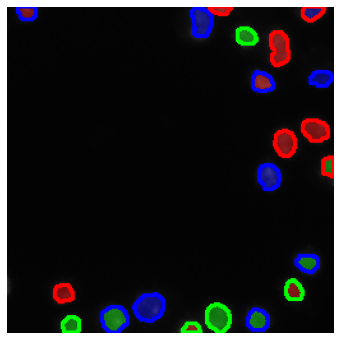

In [ ]:
# 단일 image에 대한 instance segmentation 시각화 진행
color_list = [(0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
              ]

val_df_id = val_df['image_id_list'].iloc[0]
val_df_image_name = val_df[val_df['image_id_list'] == val_df_id]['image_name_path'].to_list()
image_array = cv2.cvtColor(cv2.imread(val_df_image_name[0]), cv2.COLOR_BGR2RGB)

annids = coco_val.getAnnIds(imgIds=[val_df_id], catIds=[0], iscrowd=None)
anns = coco_val.loadAnns(annids)
ann_seg_list = [ann['segmentation'][0] for ann in anns]
masked_image = draw_instance_segmentation(image_array, ann_seg_list, color_list, alpha=0.6)

plt.figure(figsize=(6, 6))
plt.imshow(masked_image)
plt.axis('off')
plt.show()

In [ ]:
# 전체 image에 대한 instance segmentation 시각화 진행
def show_coco_image(data_df, image_id_list, ncols):
    fig, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        image_id = image_id_list[i]
        image_name = data_df[data_df['image_id_list'] == image_id]['image_name_path'].to_list()[0]
        image_array = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    
        axs[i].imshow(image_array)
        axs[i].set_title('original image' + str(i+1))
        axs[i].axis('off')

def show_coco_masked_image(coco, data_df, image_id_list, ncols):
    fig, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        image_id = image_id_list[i]
        image_name = data_df[data_df['image_id_list'] == image_id]['image_name_path'].to_list()[0]
        image_array = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)

        annids = coco.getAnnIds(imgIds=[image_id], catIds=[0], iscrowd=None)
        anns = coco.loadAnns(annids)
        ann_seg_list = [ann['segmentation'][0] for ann in anns]
        masked_image = draw_instance_segmentation(image_array, ann_seg_list, color_list, alpha=0.6)
    
        axs[i].imshow(masked_image)
        axs[i].set_title('masked image' + str(i+1))
        axs[i].axis('off')

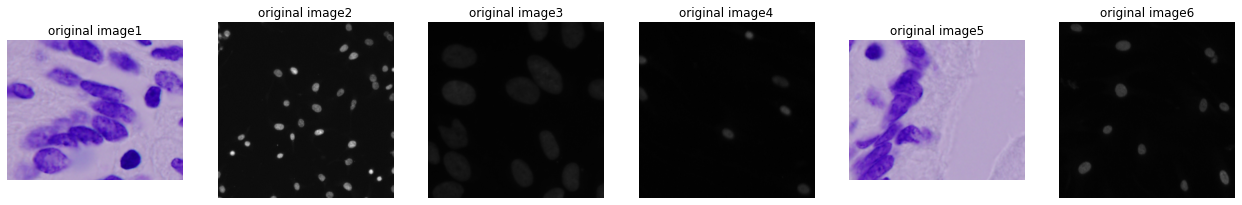

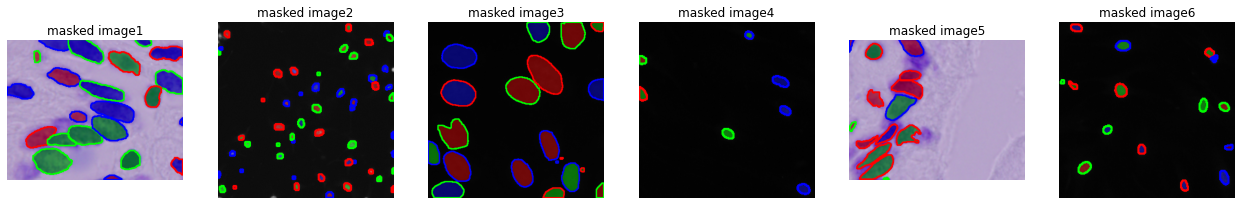

In [ ]:
show_coco_image(train_df, train_ids[:6], ncols=6)
show_coco_masked_image(coco_train, train_df, train_ids[:6], ncols=6)

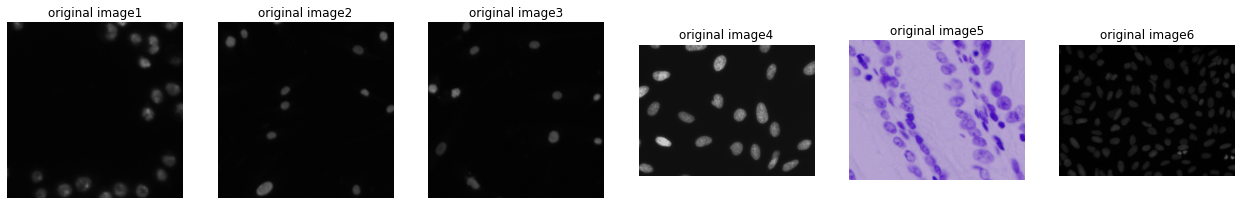

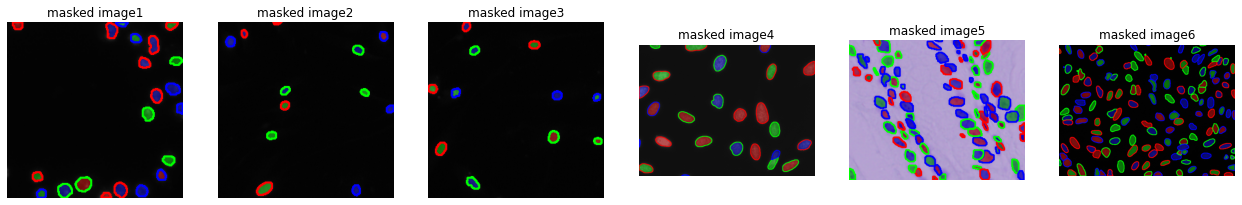

In [ ]:
show_coco_image(val_df, val_ids[:6], ncols=6)
show_coco_masked_image(coco_val, val_df, val_ids[:6], ncols=6)